# GTD2 - GTD - TDC - TD

In [1]:
import numpy as np
from matplotlib import pyplot as plt

/Users/Greta/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [177]:
class randomwalk : 
    
    def __init__(self,states,Phi,Pi,D,P,R,dim_features) : 
        
        self.states = states
        self.Phi= Phi
        self.Pi = Pi
        self.R = R
        self.D = D
        self.P = P
        self.dim_features = dim_features
        
    def which_action(self) : 
        r = np.random.uniform(0,1)
        if r > 0.5 : 
            return 'l'
        else : 
            return 'r'

    def new_state(self,s,action) : 
        # refer to the state by the letter
        if s == 'tl' or s == 'tr' : 
            new_s = s
        else : 
            position = self.states.index(s)
            if action == 'l' : 
                position = position - 1
            elif action == 'r' : 
                position = position + 1
            new_s = self.states[position]

        return new_s

    def reward(self,new_s): 
        reward = 0
        if new_s == 'tr' : 
            reward = 1

        return reward

    def delta(self,r,discount,theta,fi_prime,fi):
        delt = r + discount * np.dot(theta,fi_prime) - np.dot(theta,fi)
        return delt

    def phi_states(self,s,new_s) : 
        fi = self.Phi[self.states.index(s)-1]
        fi_prime = np.zeros((self.dim_features,))
        if new_s != 'tr' and new_s != 'tl' : 
            fi_prime = self.Phi[self.states.index(new_s)-1]
        return fi,fi_prime
    
    def compute_rmspbe(self,discount,theta) :
        v = np.dot(self.Phi,theta)
        pitv = R + discount * np.dot(self.P,v)
        mspbe = np.sum((v-pitv)**2)/5.
        rmspbe = np.sqrt(mspbe)
        return rmspbe
    
    def one_episode(self,algo,alpha,eta,discount,theta_o,w_o) :      
        theta = np.copy(theta_o)
        w = np.copy(w_o)
        s = 'c'
        end = False
        while end is False : 
            # take action a and observe reward and new_state
            a = self.which_action()
            new_s = self.new_state(s,a)
            r = self.reward(new_s)
            fi,fi_prime = self.phi_states(s,new_s)
            
            # update values
            delt = self.delta(r,discount,theta,fi_prime,fi)
            if algo == 'GTD2' : 
                theta = theta + alpha * (fi - discount * fi_prime) * np.dot(fi,w)
                w = w + alpha * eta * (delt - np.dot(fi,w)) * fi 
            
            elif algo == 'TDC' : 
                theta = theta + alpha * delt * fi - alpha * discount * fi_prime * np.dot(fi,w)
                w = w + alpha * eta * (delt - np.dot(fi,w)) * fi                
            
            elif algo == 'GTD' : 
                theta = theta + alpha * (fi - discount * fi_prime) * np.dot(fi,w)
                w = w + alpha * eta * (delt*fi - w)               

            # end if we reached the terminal state
            if new_s == 'tr' or new_s == 'tl' : 
                end = True

            s = new_s
        
        rmspbe_measure = self.compute_rmspbe(discount,theta)
        
        return theta,w,rmspbe_measure
    
    def one_alpha(self,algo,eta,alpha,discount,nb_episodes) : 
        # compute the rmspbe for one alpha and one eta. Useful to plot the learning curves
        count_episode = 0
        measures = []
        theta_o = np.zeros((self.dim_features,))
        w_o = np.zeros((self.dim_features,))
        
        while count_episode < nb_episodes : 
            theta,w,rmspbe_measure = self.one_episode(algo,alpha,eta,discount,theta_o,w_o)
            measures.append(rmspbe_measure)
            theta_o = theta
            w_o = w
            count_episode += 1
            
        return measures
        
    def one_feature_one_algo(self,algo,states,discount,alphas,etas,nb_episodes,nb_runs) : 
        # compute all the runs for one particular feature    
        saved_etas = dict()
        for eta in etas : 
            # do the 100 runs
            count_run = 0
            perf_eta = [0]*len(alphas)        
            while count_run < nb_runs : 
                # for each run, save the value of rmspbe function of alpha
                perf_eta_run = []
                
                for alpha in alphas :                  
                    measures_alpha = self.one_alpha(algo,eta,alpha,discount,nb_episodes)
                    perf_eta_run.append(measures_alpha[-1])


                for i in range(len(alphas)) : 
                    perf_eta[i] += perf_eta_run[i]
                count_run += 1

            rez_eta = [elt/float(nb_runs) for elt in perf_eta]    
            saved_etas[eta] = rez_eta
            print '%s eta = %s done' %(algo,eta)     
        return saved_etas
    
    def runs_learning_curve(self,algo,alpha,eta,discount,nb_episodes,nb_runs) : 
        perf_runs = [0]*nb_episodes
        count_run = 0
        while count_run < nb_runs :
            perf_run = self.one_alpha(algo,eta,alpha,discount,nb_episodes)
            for i in range(nb_episodes) : 
                perf_runs[i] += perf_run[i]
            count_run += 1
        perf = [elt/float(nb_runs) for elt in perf_runs]
        return perf
    
    ########### TD ####################
    
    def one_episode_td(self,alpha,discount,theta_o) : 
        theta = np.copy(theta_o)
        s = 'c'
        end = False
        while end is False : 
            # choose action according to pi and observe R and S'
            a = self.which_action()
            new_s = self.new_state(s,a)
            r = self.reward(new_s)
            fi,fi_prime = self.phi_states(s,new_s)
            
            # update values
            delt = self.delta(r,discount,theta,fi_prime,fi)
            theta = theta + alpha * delt * fi

            if new_s == 'tl' or new_s == 'tr' : 
                end = True

            s = new_s
            
        rmspbe_measure = self.compute_rmspbe(discount,theta)
        
        return theta,rmspbe_measure
    
    def one_run_td(self,alphas,nb_episodes,discount) : 
        # one run is 500 episodes 
        perf = []
        for alpha in alphas : 
            
            count_episode = 0
            measures = []
            theta_o = np.zeros((self.dim_features,))

            while count_episode < nb_episodes : 
                theta,rmspbe_measure = self.one_episode_td(alpha,discount,theta_o)
                measures.append(rmspbe_measure)
                theta_o = theta
                count_episode += 1
                         
            perf.append(measures[-1])
        
        return perf
    
    def all_runs_td(self,nb_runs,alphas,nb_episodes,discount) :
        # compute all the runs for the TD algorithm
        count_run = 0
        perf_glob = [0]*len(alphas)
        while count_run < 100 : 
            perf_run = self.one_run_td(alphas,nb_episodes,discount)

            for i in range(len(alphas)) : 
                perf_glob[i] += perf_run[i]

            if count_run % 10 == 0 :     
                print 'run %s done'%count_run
            count_run += 1

        res = [elt/100. for elt in perf_glob]
        return res
    
    def runs_learning_curve_td(self,nb_runs,alpha,nb_episodes,discount) : 
        count_run = 0
        perf_glob = [0]*nb_episodes
        while count_run < nb_runs : 
            
            count_episode = 0
            measures_run = []
            theta_o = np.zeros((self.dim_features,))

            while count_episode < nb_episodes : 
                theta,rmspbe_measure = self.one_episode_td(alpha,discount,theta_o)
                measures_run.append(rmspbe_measure)
                theta_o = theta
                count_episode += 1
            
            for i in range(nb_episodes) : 
                perf_glob[i] += measures_run[i]
                        
            count_run +=1
        
        res = [elt/float(nb_runs) for elt in perf_glob]
        return res     

### Define environment

In [178]:
states = ['tl','a','b','c','d','e','tr']
discount = 1.
alphas = [0.03,0.06,0.12,0.25,0.3,0.4,0.5]
etas = [0.25,0.5,1.,2.]
nb_episodes = 500
nb_runs = 100

In [179]:
D = np.diag(np.ones((5,))/5.)
P = np.array([[0,0.5,0,0,0],[0.5,0,0.5,0,0],[0,0.5,0,0.5,0],[0,0,0.5,0,0.5],[0,0,0,0.5,0]])
R = np.array([0.,0.,0.,0.,0.5])

# RMSPBE and LEARNING CURVES

## Tabular features

In [180]:
dim_tab = 5
Phi_tab = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
B_tab = np.linalg.inv((Phi_tab.T).dot(D).dot(Phi_tab))
Pi_tab = Phi_tab.dot(B_tab).dot(Phi_tab.T).dot(D)
env_tab = randomwalk(states,Phi_tab,Pi_tab,D,P,R,dim_tab)

In [130]:
runs_tab_gtd = env_tab.one_feature_one_algo('GTD',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD eta = 0.25 done
GTD eta = 0.5 done
GTD eta = 1.0 done
GTD eta = 2.0 done


In [132]:
runs_tab_gtd2 = env_tab.one_feature_one_algo('GTD2',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD2 eta = 0.25 done
GTD2 eta = 0.5 done
GTD2 eta = 1.0 done
GTD2 eta = 2.0 done


In [133]:
runs_tab_tdc = env_tab.one_feature_one_algo('TDC',states,discount,alphas,etas,nb_episodes,nb_runs)

TDC eta = 0.25 done
TDC eta = 0.5 done
TDC eta = 1.0 done
TDC eta = 2.0 done


In [134]:
runs_tab_td = env_tab.all_runs_td(nb_runs,alphas,nb_episodes,discount)

run 0 done
run 10 done
run 20 done
run 30 done
run 40 done
run 50 done
run 60 done
run 70 done
run 80 done
run 90 done


In [181]:
tab_gtd2 = env_tab.runs_learning_curve('GTD2',0.06,0.5,discount,nb_episodes,nb_runs)
tab_gtd = env_tab.runs_learning_curve('GTD',0.3,0.5,discount,nb_episodes,nb_runs)
tab_td = env_tab.runs_learning_curve_td(nb_runs,0.047,nb_episodes,discount)
tab_tdc = env_tab.runs_learning_curve('TDC',0.06,0.5,discount,nb_episodes,nb_runs)

### Parameter study

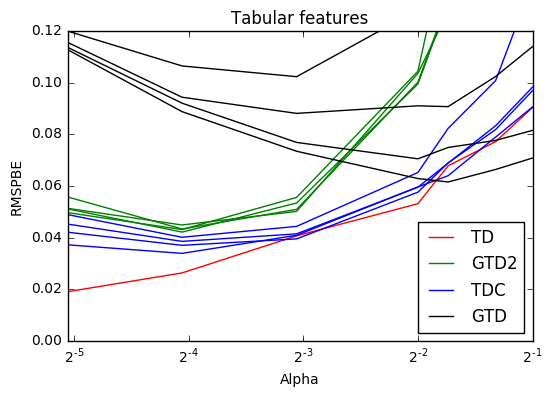

In [135]:
fig,ax = plt.subplots()
x = [0.03,0.06,0.12,0.25,0.3,0.4,0.5]

ax.plot(x,runs_tab_td,color = 'r',label = 'TD') 

ax.plot(x,runs_tab_gtd2[0.25],color = 'g',label = 'GTD2')
ax.plot(x,runs_tab_gtd2[0.5],color = 'g')
ax.plot(x,runs_tab_gtd2[1],color = 'g')
ax.plot(x,runs_tab_gtd2[2],color = 'g')

ax.plot(x,runs_tab_tdc[0.25],color = 'b',label = 'TDC')
ax.plot(x,runs_tab_tdc[0.5],color = 'b')
ax.plot(x,runs_tab_tdc[1],color = 'b')
ax.plot(x,runs_tab_tdc[2],color = 'b')

ax.plot(x,runs_tab_gtd[0.25],color = 'k',label = 'GTD')
ax.plot(x,runs_tab_gtd[0.5],color = 'k')
ax.plot(x,runs_tab_gtd[1],color = 'k')
ax.plot(x,runs_tab_gtd[2],color = 'k')

plt.xlabel('Alpha')
plt.ylabel('RMSPBE')
plt.title('Tabular features')
plt.ylim((0,0.12))
ax.set_xscale('log',basex = 2)
plt.xlim((0.03,0.5))
plt.legend(loc = 'lower right')
plt.show()

### Learning curves

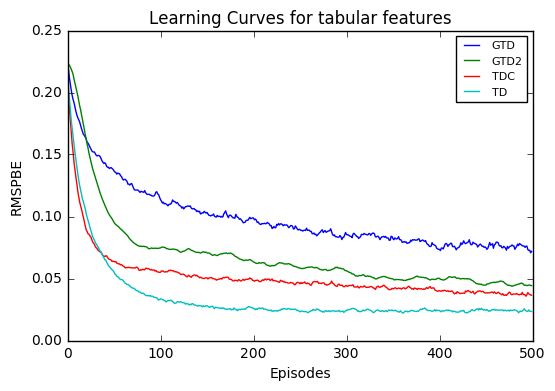

In [192]:
plt.plot(range(nb_episodes),tab_gtd,label='GTD')
plt.plot(range(nb_episodes),tab_gtd2,label='GTD2')
plt.plot(range(nb_episodes),tab_tdc,label='TDC')
plt.plot(range(nb_episodes),tab_td,label='TD')

plt.xlabel('Episodes')
plt.ylabel('RMSPBE')
plt.title('Learning Curves for tabular features')
plt.legend(loc='upper right',fontsize=8)
plt.show()

## Inverted features

In [193]:
dim_inv = 5
Phi_inv = 0.5 * np.ones((5,5)) - 0.5 * np.identity(5)
B_inv = np.linalg.inv((Phi_inv.T).dot(D).dot(Phi_inv))
Pi_inv = Phi_inv.dot(B_inv).dot(Phi_inv.T).dot(D)
env_inv = randomwalk(states,Phi_inv,Pi_inv,D,P,R,dim_inv)

In [194]:
runs_inv_gtd = env_inv.one_feature_one_algo('GTD',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD eta = 0.25 done
GTD eta = 0.5 done
GTD eta = 1.0 done
GTD eta = 2.0 done


In [195]:
runs_inv_gtd2 = env_inv.one_feature_one_algo('GTD2',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD2 eta = 0.25 done
GTD2 eta = 0.5 done
GTD2 eta = 1.0 done
GTD2 eta = 2.0 done


In [196]:
runs_inv_tdc = env_inv.one_feature_one_algo('TDC',states,discount,alphas,etas,nb_episodes,nb_runs)

TDC eta = 0.25 done
TDC eta = 0.5 done
TDC eta = 1.0 done
TDC eta = 2.0 done


In [197]:
runs_inv_td = env_inv.all_runs_td(nb_runs,alphas,nb_episodes,discount)

run 0 done
run 10 done
run 20 done
run 30 done
run 40 done
run 50 done
run 60 done
run 70 done
run 80 done
run 90 done


In [203]:
inv_gtd2 = env_inv.runs_learning_curve('GTD2',0.06,0.5,discount,nb_episodes,nb_runs)
inv_gtd = env_inv.runs_learning_curve('GTD',0.03,0.5,discount,nb_episodes,nb_runs)
inv_tdc = env_inv.runs_learning_curve('TDC',0.06,0.5,discount,nb_episodes,nb_runs)
inv_td = env_inv.runs_learning_curve_td(nb_runs,0.047,nb_episodes,discount)

### Parameter study

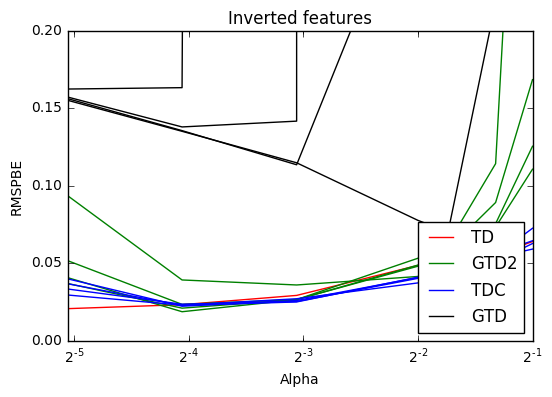

In [198]:
fig,ax = plt.subplots()
x = [0.03,0.06,0.12,0.25,0.3,0.4,0.5]

ax.plot(x,runs_inv_td,color = 'r',label = 'TD') 

ax.plot(x,runs_inv_gtd2[0.25],color = 'g',label = 'GTD2')
ax.plot(x,runs_inv_gtd2[0.5],color = 'g')
ax.plot(x,runs_inv_gtd2[1],color = 'g')
ax.plot(x,runs_inv_gtd2[2],color = 'g')

ax.plot(x,runs_inv_tdc[0.25],color = 'b',label = 'TDC')
ax.plot(x,runs_inv_tdc[0.5],color = 'b')
ax.plot(x,runs_inv_tdc[1],color = 'b')
ax.plot(x,runs_inv_tdc[2],color = 'b')

ax.plot(x,runs_inv_gtd[0.25],color = 'k',label = 'GTD')
ax.plot(x,runs_inv_gtd[0.5],color = 'k')
ax.plot(x,runs_inv_gtd[1],color = 'k')
ax.plot(x,runs_inv_gtd[2],color = 'k')

plt.xlabel('Alpha')
plt.ylabel('RMSPBE')
plt.title('Inverted features')
plt.ylim((0,0.20))
ax.set_xscale('log',basex = 2)
plt.xlim((0.03,0.5))
plt.legend(loc = 'lower right')
plt.show()

### Learning Curves

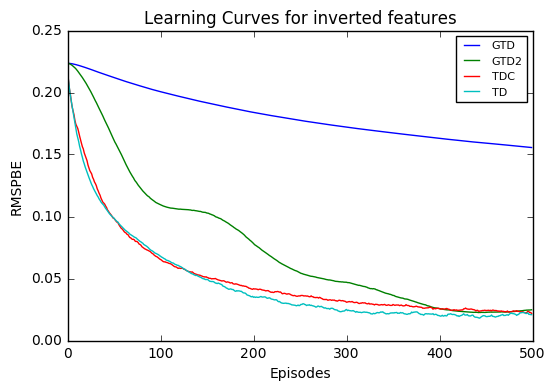

In [204]:
plt.plot(range(nb_episodes),inv_gtd,label='GTD')
plt.plot(range(nb_episodes),inv_gtd2,label='GTD2')
plt.plot(range(nb_episodes),inv_tdc,label='TDC')
plt.plot(range(nb_episodes),inv_td,label='TD')

plt.xlabel('Episodes')
plt.ylabel('RMSPBE')
plt.title('Learning Curves for inverted features')
plt.legend(loc='upper right',fontsize=8)
plt.show()

## Dependent Features

In [205]:
dim_dep = 3
Phi_dep = np.array([[1,0,0],[1./np.sqrt(2),1./np.sqrt(2),0],[1./np.sqrt(3),1./np.sqrt(3),1./np.sqrt(3)],[0,1./np.sqrt(2),1./np.sqrt(2)],[0,0,1]])
B_dep = np.linalg.inv((Phi_dep.T).dot(D).dot(Phi_dep))
Pi_dep = Phi_dep.dot(B_dep).dot(Phi_dep.T).dot(D)
env_dep = randomwalk(states,Phi_dep,Pi_dep,D,P,R,dim_dep)

In [206]:
runs_dep_gtd = env_dep.one_feature_one_algo('GTD',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD eta = 0.25 done
GTD eta = 0.5 done
GTD eta = 1.0 done
GTD eta = 2.0 done


In [207]:
runs_dep_gtd2 = env_dep.one_feature_one_algo('GTD2',states,discount,alphas,etas,nb_episodes,nb_runs)

GTD2 eta = 0.25 done
GTD2 eta = 0.5 done
GTD2 eta = 1.0 done
GTD2 eta = 2.0 done


In [208]:
runs_dep_tdc = env_dep.one_feature_one_algo('TDC',states,discount,alphas,etas,nb_episodes,nb_runs)

TDC eta = 0.25 done
TDC eta = 0.5 done
TDC eta = 1.0 done
TDC eta = 2.0 done


In [209]:
runs_dep_td = env_dep.all_runs_td(nb_runs,alphas,nb_episodes,discount)

run 0 done
run 10 done
run 20 done
run 30 done
run 40 done
run 50 done
run 60 done
run 70 done
run 80 done
run 90 done


In [210]:
dep_gtd2 = env_dep.runs_learning_curve('GTD2',0.01,0.5,discount,nb_episodes,nb_runs)
dep_gtd = env_dep.runs_learning_curve('GTD',0.01,0.5,discount,nb_episodes,nb_runs)
dep_tdc = env_dep.runs_learning_curve('TDC',0.01,0.5,discount,nb_episodes,nb_runs)
dep_td = env_dep.runs_learning_curve_td(nb_runs,0.01,nb_episodes,discount)

### Parameter study

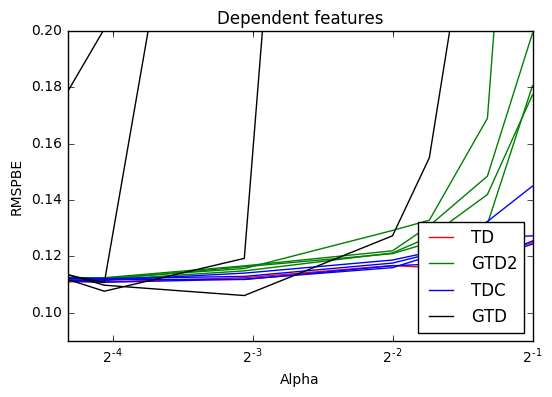

In [211]:
fig,ax = plt.subplots()
x = [0.03,0.06,0.12,0.25,0.3,0.4,0.5]

ax.plot(x,runs_dep_td,color = 'r',label = 'TD') 

ax.plot(x,runs_dep_gtd2[0.25],color = 'g',label = 'GTD2')
ax.plot(x,runs_dep_gtd2[0.5],color = 'g')
ax.plot(x,runs_dep_gtd2[1],color = 'g')
ax.plot(x,runs_dep_gtd2[2],color = 'g')

ax.plot(x,runs_dep_tdc[0.25],color = 'b',label = 'TDC')
ax.plot(x,runs_dep_tdc[0.5],color = 'b')
ax.plot(x,runs_dep_tdc[1],color = 'b')
ax.plot(x,runs_dep_tdc[2],color = 'b')

ax.plot(x,runs_dep_gtd[0.25],color = 'k',label = 'GTD')
ax.plot(x,runs_dep_gtd[0.5],color = 'k')
ax.plot(x,runs_dep_gtd[1],color = 'k')
ax.plot(x,runs_dep_gtd[2],color = 'k')

plt.xlabel('Alpha')
plt.ylabel('RMSPBE')
plt.title('Dependent features')
plt.ylim((0.09,0.20))
ax.set_xscale('log',basex = 2)
plt.xlim((0.05,0.5))
plt.legend(loc = 'lower right')
plt.show()

### Learning Curves

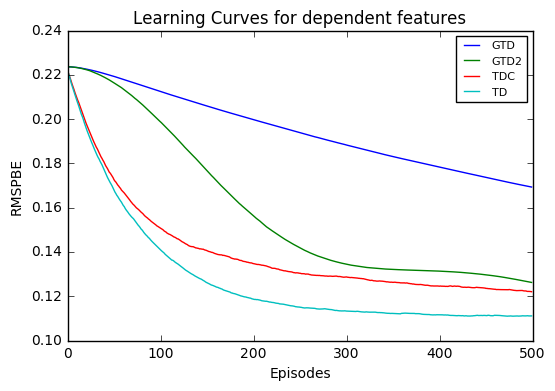

In [212]:
plt.plot(range(nb_episodes),dep_gtd,label='GTD')
plt.plot(range(nb_episodes),dep_gtd2,label='GTD2')
plt.plot(range(nb_episodes),dep_tdc,label='TDC')
plt.plot(range(nb_episodes),dep_td,label='TD')

plt.xlabel('Episodes')
plt.ylabel('RMSPBE')
plt.title('Learning Curves for dependent features')
plt.legend(loc='upper right',fontsize=8)
plt.show()